# Yeast 

Esse Jupyter Notebook apresenta nosso estudo e os resultados obtidos para o conjunto de dados *yeast*.

In [6]:
# Instalação dos pacotes
# !pip install --upgrade pip
# !pip install scikit-multilearn
# !pip install scipy
# !pip install pandas
# !pip install matplotlib
# !pip install numpy
# !pip install -U scikit-learn

## Leitura dos dados e Pré-processamento

A função convert é responsável por transformar dados categóricos e binários para dados numéricos.

In [7]:
def convert(a):
    # tenta converter para uma string
    try:
        b = a.decode("utf-8")
    except:
        # eh um numero
        return a
    # tenta converter para um inteiro
    try:
        return int(b)
    except:
        # eh um atributo nominal
        if b == 'YES':
            return 1
        if b == 'NO':
            return 0
        return b

In [8]:
# Imports necessários para extraçao dos dados
import scipy
from scipy.io import arff
import pandas as pd

# Carregando o treino
data_train, meta_train = scipy.io.arff.loadarff(f'datasets/yeast/yeast-train.arff')
X_train = pd.DataFrame(data_train)

# Carregando o teste
data_test, meta_test = scipy.io.arff.loadarff(f'datasets/yeast/yeast-test.arff')
X_test = pd.DataFrame(data_test)

# Pré-processamento
# Transformando em atributos numéricos
X_test = X_test.applymap(convert)
X_train = X_train.applymap(convert)


# # Separando o Y do treino
Y_train = X_train.iloc[:, -14:]
X_train.drop(columns=list(Y_train.columns), inplace=True)

# # Separando o Y do teste
Y_test = X_test.iloc[:, -14:]
X_test.drop(columns=list(Y_test.columns), inplace=True)


In [9]:
# Verificando se o pré-processamento foi bem sucedida nos rótulos.
Y_test

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,1,1,1,0,0,0,0,0,0,0,0,0,0,0
913,1,1,1,0,0,0,0,0,0,0,0,1,1,0
914,1,1,0,0,0,0,0,0,0,0,0,1,1,0
915,0,1,1,0,0,0,1,1,0,0,0,1,1,0


## Algoritmos
Vamos estudar esse conjunto de dados com três métodos de classificação multirrótulo:
- Binary Relevance
- Classifier Chains
- Label Powersets.

Também utilizamos dois classificadores de um rótulo para cada classificador multirrótulo, são eles:
- Decision Tree Classifier
- Random Forest Classifier. 



### Binary Relevance

In [10]:
# Começamos com o Binary Relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Realizamos uma Cross Validation para determinarmos os melhores
# parâmetros de execução do algoritmo de classificação multirrótulo.
# Dentre esses parâmetros, está o classificador que vamos utilizar
# para resolver o problema após conversão para um rótulo.


grid_param = [ 
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [10, 50, 100],
        'classifier__random_state': [42],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False],
        'classifier__random_state': [42],
    },
]

br = GridSearchCV(BinaryRelevance(), grid_param, scoring='accuracy')

br.fit(X_train.values, Y_train.values)


GridSearchCV(estimator=BinaryRelevance(require_dense=[True, True]),
             param_grid=[{'classifier': [DecisionTreeClassifier()],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [10, 50, 100],
                          'classifier__random_state': [42]},
                         {'classifier': [RandomForestClassifier(bootstrap=False,
                                                                criterion='entropy',
                                                                random_state=42)],
                          'classifier__bootstrap': [True, False],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__random_state': [42]}],
             scoring='accuracy')

In [11]:
# Valor de acurácia da melhor escolha do Cross Validation
br.best_score_

0.16533333333333333

In [12]:
# Melhores parâmetros escolhidos pelo Cross Validation
br.best_params_

{'classifier': RandomForestClassifier(bootstrap=False, criterion='entropy', random_state=42),
 'classifier__bootstrap': False,
 'classifier__criterion': 'entropy',
 'classifier__random_state': 42}

In [13]:
# Melhores parâmetros escolhidos pelo Cross Validation
# De forma simplificada
br.best_estimator_

BinaryRelevance(classifier=RandomForestClassifier(bootstrap=False,
                                                  criterion='entropy',
                                                  random_state=42),
                require_dense=[True, True])

In [14]:
# Realiza o fit com os parâmetros escolhidos 
br = br.best_estimator_
br.fit(X_train.values, Y_train.values)


BinaryRelevance(classifier=RandomForestClassifier(bootstrap=False,
                                                  criterion='entropy',
                                                  random_state=42),
                require_dense=[True, True])

In [15]:
# Testa a qualidade da solução
from sklearn.metrics import accuracy_score

# Verificar acurácia
pred = br.predict(X_test.values)
accuracy_score(Y_test.values, pred)


0.16902944383860413

In [16]:
# Verificar o Hamming Loss
from sklearn.metrics import hamming_loss
hamming_loss(Y_test.values, pred)

0.19193020719738277

### Classifier Chains

In [17]:
# Vamos utilizar o Classifier Chains
from skmultilearn.problem_transform import ClassifierChain
# Realizamos uma Cross Validation para determinarmos os melhores
# parâmetros de execução do algoritmo de classificação multirrótulo.
# Dentre esses parâmetros, está o classificador que vamos utilizar
# para resolver o problema após conversão para um rótulo.

grid_param = [ 
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [10, 50, 100],
        'classifier__random_state': [42],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False],
        'classifier__random_state': [42],
    },
]

cc = GridSearchCV(ClassifierChain(), grid_param, scoring='accuracy')
cc.fit(X_train.values, Y_train.values)

GridSearchCV(estimator=ClassifierChain(require_dense=[True, True]),
             param_grid=[{'classifier': [DecisionTreeClassifier()],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [10, 50, 100],
                          'classifier__random_state': [42]},
                         {'classifier': [RandomForestClassifier(bootstrap=False,
                                                                random_state=42)],
                          'classifier__bootstrap': [True, False],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__random_state': [42]}],
             scoring='accuracy')

In [18]:
cc.best_score_

0.23066666666666666

In [19]:
cc.best_params_

{'classifier': RandomForestClassifier(bootstrap=False, random_state=42),
 'classifier__bootstrap': False,
 'classifier__criterion': 'gini',
 'classifier__random_state': 42}

In [20]:
cc.best_estimator_

ClassifierChain(classifier=RandomForestClassifier(bootstrap=False,
                                                  random_state=42),
                require_dense=[True, True])

In [21]:
# Realiza o fit com os parâmetros escolhidos 
cc = cc.best_estimator_
cc.fit(X_train.values, Y_train.values)

ClassifierChain(classifier=RandomForestClassifier(bootstrap=False,
                                                  random_state=42),
                require_dense=[True, True])

In [22]:
# Verificar acurácia
pred2 = cc.predict(X_test.values)
accuracy_score(Y_test.values, pred2)

0.23446019629225737

In [23]:
# Verificar o Hamming Loss
hamming_loss(Y_test.values, pred2)

0.19247546346782987

### Label Powerset

In [24]:
# Vamos utilizar o Label Powerset
from skmultilearn.problem_transform import LabelPowerset
# Realizamos uma Cross Validation para determinarmos os melhores
# parâmetros de execução do algoritmo de classificação multirrótulo.
# Dentre esses parâmetros, está o classificador que vamos utilizar
# para resolver o problema após conversão para um rótulo.

grid_param = [ 
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [10, 50, 100],
        'classifier__random_state': [42],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False],
        'classifier__random_state': [42],
    },
]

lp = GridSearchCV(LabelPowerset(), grid_param, scoring='accuracy')
lp.fit(X_train.values, Y_train.values)

GridSearchCV(estimator=LabelPowerset(require_dense=[True, True]),
             param_grid=[{'classifier': [DecisionTreeClassifier()],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [10, 50, 100],
                          'classifier__random_state': [42]},
                         {'classifier': [RandomForestClassifier(bootstrap=False,
                                                                criterion='entropy',
                                                                random_state=42)],
                          'classifier__bootstrap': [True, False],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__random_state': [42]}],
             scoring='accuracy')

In [25]:
lp.best_score_

0.27199999999999996

In [26]:
lp.best_params_

{'classifier': RandomForestClassifier(bootstrap=False, criterion='entropy', random_state=42),
 'classifier__bootstrap': False,
 'classifier__criterion': 'entropy',
 'classifier__random_state': 42}

In [27]:
lp.best_estimator_

LabelPowerset(classifier=RandomForestClassifier(bootstrap=False,
                                                criterion='entropy',
                                                random_state=42),
              require_dense=[True, True])

In [28]:
# Realiza o fit com os parâmetros escolhidos 
lp = lp.best_estimator_
lp.fit(X_train.values, Y_train.values)

LabelPowerset(classifier=RandomForestClassifier(bootstrap=False,
                                                criterion='entropy',
                                                random_state=42),
              require_dense=[True, True])

In [29]:
# Verificar acurácia
pred3 = lp.predict(X_test.values)
accuracy_score(Y_test.values, pred3)

0.26608505997818976

In [30]:
# Verificar o Hamming Loss
hamming_loss(Y_test.values, pred3)

0.20602897647608662

## Resultados

Agora iremos mostrar os resultados experimentais obtidos por cada algoritmo de classificação multirrótulo. 
Além disso, vamos plotar gráficos para comparar os valores de acurácia e *Hamming Loss* dos métodos.

### Resultados Experimentais

In [31]:
# Resultado predito pelo algoritmo Binary Relevance
pd.DataFrame.sparse.from_spmatrix(pred)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,1,1,0
2,0,1,0,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,1,1,0
4,0,1,1,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,0,1,1,0,0,0,0,0,0,0,0,1,1,0
913,0,0,1,0,1,0,0,0,0,0,0,1,1,0
914,0,0,1,0,0,0,0,0,0,0,0,1,1,0
915,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [32]:
# Resultado predito pelo algoritmo Classifier Chains
pd.DataFrame.sparse.from_spmatrix(pred2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
914,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [33]:
# Resultado predito pelo algoritmo Label Powerset
pd.DataFrame.sparse.from_spmatrix(pred3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,0,0,1,1,0,0,0,0,0,0,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,1,1,0
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,1,1,0
4,0,0,1,1,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,0,0,1,1,0,0,0,0,0,0,0,1,1,0
913,0,1,1,0,0,0,0,0,0,0,0,1,1,0
914,0,0,1,1,0,0,0,0,0,0,0,1,1,0
915,0,0,1,1,0,0,0,0,0,0,0,1,1,0


In [34]:
# Valores de rotulos apresentados pelo conjunto de treino
Y_test

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,1,1,1,0,0,0,0,0,0,0,0,0,0,0
913,1,1,1,0,0,0,0,0,0,0,0,1,1,0
914,1,1,0,0,0,0,0,0,0,0,0,1,1,0
915,0,1,1,0,0,0,1,1,0,0,0,1,1,0


### Gráficos
Vamos plotar o gráfico de acurácia.

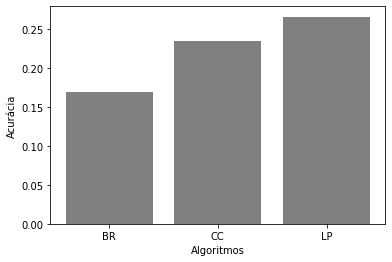

In [35]:
# Plot das acurácias dos métodos multirrótulos.
import numpy as np
import matplotlib.pyplot as plt
# Vamos plotar um gráfico de barras

# Eixo X
algorithms = ['BR', 'CC', 'LP']
# Eixo Y
val_acc = [accuracy_score(Y_test.values, pred), accuracy_score(Y_test.values, pred2), accuracy_score(Y_test.values, pred3)]

# Barras do gráfico
plt.bar(algorithms, val_acc, color="gray")

# Nome das barras
plt.xticks(algorithms)

# Informação do eixo y
plt.ylabel('Acurácia')

# Informação do eixo X
plt.xlabel('Algoritmos')



plt.show()

Plot do gráfico de *Hamming Loss*.

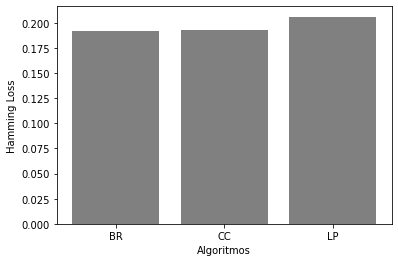

In [36]:
# Plot dos Hamming Loss dos métodos multirrótulos.
# Vamos plotar um gráfico de barras

# Eixo X
algorithms = ['BR', 'CC', 'LP']
# Eixo Y
val_acc = [hamming_loss(Y_test.values, pred), hamming_loss(Y_test.values, pred2), hamming_loss(Y_test.values, pred3)]

# Barras do gráfico
plt.bar(algorithms, val_acc, color="gray")

# Nome das barras
plt.xticks(algorithms)

# Informação do eixo y
plt.ylabel('Hamming Loss')

# Informação do eixo X
plt.xlabel('Algoritmos')

plt.show()

## Conclusão

Dessa forma, segundo nossos experimentos e os resultados apresentados graficamente, podemos concluir que o método Label Powerset apresenta um desempenho melhor em relação à acurácia, embora o método Classifier Chains tenha apresentado um melhor *score* de *Hamming loss* para o *database* yeast. É importante ressaltar que, em termos de acurácia, todos os classificadores tiveram um baixo desempenho.
